In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

# raw_data_path = '../input/goodreads10kcsv/'
# model_ouput_path = '../input/goodreads-models/'

raw_data_path = './data/raw/goodbooks-10k/'
model_ouput_path = './data/models/'

ratings_df = pd.read_csv(raw_data_path + 'ratings.csv' , dtype={'rating': np.uint8,
                                                       'user_id': np.uint16,
                                                       'book_id': np.uint16})

# Hyperparameter Search

In [2]:
from scipy.sparse import csr_matrix

In [3]:
ratings_matrix = csr_matrix((ratings_df.rating.values,(ratings_df.user_id.values-1, ratings_df.book_id.values-1)))

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.decomposition import NMF
from datetime import datetime

Let's check the RMSE of the unregularized model.

In [6]:
n_components = 50

In [7]:
model = NMF(n_components=n_components
#            verbose=1
           )

In [8]:
W = model.fit_transform(ratings_matrix)
H = model.components_
print('The RMSE for the unregularized model is: %.2f' % model.reconstruction_err_)

The RMSE for the unregularized model is: 8545.79


In [9]:
from sklearn.model_selection import ParameterGrid

In [10]:
model = NMF(n_components=n_components
#            verbose=1
           )

In [11]:
# current grid
param1 = 'alpha'
param2 = 'l1_ratio'

param_grid = {
    param1: list(np.round(np.geomspace(1e1, 1e3, 5), 3)),
    param2: list(np.round(np.linspace(0.1, 0.9, 5), 8))
}

In [12]:
rows = []
cols = []
errors = []
density = []

for params in ParameterGrid(param_grid):
    print(datetime.now())
    print(params)
    model.set_params(**params)
    W = model.fit_transform(ratings_matrix)
    H = model.components_
    rows.append(params[param1])
    cols.append(params[param2])
    errors.append(model.reconstruction_err_)
    A = model.inverse_transform(W)
    A_density = np.count_nonzero(A) / (A.shape[0] * A.shape[1])
    density.append(A_density)
    
print(datetime.now())

2019-07-21 06:26:04.000665
{'alpha': 10.0, 'l1_ratio': 0.1}
2019-07-21 06:27:54.502060
{'alpha': 10.0, 'l1_ratio': 0.3}
2019-07-21 06:29:59.076912
{'alpha': 10.0, 'l1_ratio': 0.5}
2019-07-21 06:32:19.264789
{'alpha': 10.0, 'l1_ratio': 0.7}
2019-07-21 06:34:19.224569
{'alpha': 10.0, 'l1_ratio': 0.9}
2019-07-21 06:36:57.191909
{'alpha': 31.623, 'l1_ratio': 0.1}
2019-07-21 06:39:47.423745
{'alpha': 31.623, 'l1_ratio': 0.3}
2019-07-21 06:41:38.111715
{'alpha': 31.623, 'l1_ratio': 0.5}
2019-07-21 06:44:32.086422
{'alpha': 31.623, 'l1_ratio': 0.7}
2019-07-21 06:46:11.263458
{'alpha': 31.623, 'l1_ratio': 0.9}
2019-07-21 06:47:55.844839
{'alpha': 100.0, 'l1_ratio': 0.1}
2019-07-21 06:50:29.914199
{'alpha': 100.0, 'l1_ratio': 0.3}
2019-07-21 06:51:55.813174
{'alpha': 100.0, 'l1_ratio': 0.5}
2019-07-21 06:53:03.758155
{'alpha': 100.0, 'l1_ratio': 0.7}
2019-07-21 06:54:36.658804
{'alpha': 100.0, 'l1_ratio': 0.9}
2019-07-21 06:56:03.559119
{'alpha': 316.228, 'l1_ratio': 0.1}
2019-07-21 06:57:42.75

In [13]:
names = ['errors', 'density']

In [14]:
scores = [errors, density]

In [15]:
scores = np.array(scores).T#.reshape((len(metrics_dict.keys()),
                          #         len(decisions))).T

In [16]:
scores_df = pd.concat([pd.DataFrame(data=np.array([rows, cols]).T,
             columns=[param1, param2]), 
    pd.DataFrame(data=scores,
             columns=names)],
            axis=1).melt(id_vars=[param1, param2])

scores_df.rename(columns={'variable': 'score'}, inplace=True)

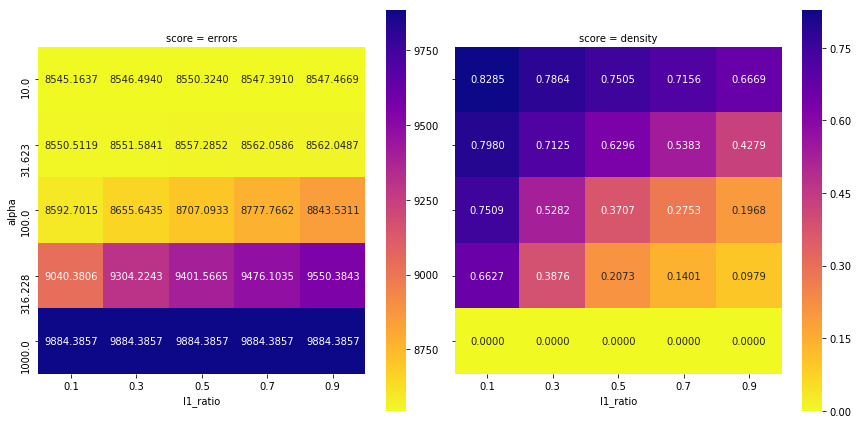

In [17]:
import seaborn as sns

def draw_heatmap(index, columns, values, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=index,
                   columns=columns,
                   values=values)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(scores_df,
                   col='score',
                   col_wrap=2,
                   height=6)

fg.map_dataframe(draw_heatmap,
                 index=param1, 
                 columns=param2,
                 values='value',
                 square=True,
                 annot=True,
                 fmt='.4f',
                 cmap='plasma_r'              
#                 cbar_kws={"orientation": "horizontal"}
                 )

fg.set_axis_labels(param2, param1)

plt.savefig('hyperparameter-search' + str(n_components) + '.png')